In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import numpy as np
from xgboost import plot_importance
from sklearn.preprocessing import Imputer

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [6]:
data = pd.read_json('data/odds.json').T[['home', 'away', 'home_win', 'draw', 'away_win', 'result']]
data.sort_values(['home_win'], ascending=False).head()

,home,away,home_win,draw,away_win,result
6DS3lu5S,San Marino,Poland,98,26.93,1.01,2
Sh5Oqv3i,Liechtenstein,Spain,80.95,35.43,1.01,2
lAfiDiAM,San Marino,Czech Republic,68.78,26.56,1.01,2
6qH9zMzT,San Marino,England,68.5,22.75,1.01,2
U7Y3orLC,Andorra,Switzerland,67.23,20.23,1.03,2


In [56]:

X = data[['home_win', 'draw', 'away_win']].astype(float)
y = data['result'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

model = xgb.XGBClassifier(max_depth=2, min_child_weight=6)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.84%


In [50]:
model = xgb.XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=eval_set, verbose=True)

[0]	validation_0-mlogloss:1.06159
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.03019
[2]	validation_0-mlogloss:1.00359
[3]	validation_0-mlogloss:0.981066
[4]	validation_0-mlogloss:0.961865
[5]	validation_0-mlogloss:0.944591
[6]	validation_0-mlogloss:0.930786
[7]	validation_0-mlogloss:0.91842
[8]	validation_0-mlogloss:0.907559
[9]	validation_0-mlogloss:0.898352
[10]	validation_0-mlogloss:0.890535
[11]	validation_0-mlogloss:0.883648
[12]	validation_0-mlogloss:0.878203
[13]	validation_0-mlogloss:0.873234
[14]	validation_0-mlogloss:0.868891
[15]	validation_0-mlogloss:0.864884
[16]	validation_0-mlogloss:0.861956
[17]	validation_0-mlogloss:0.859098
[18]	validation_0-mlogloss:0.85697
[19]	validation_0-mlogloss:0.854978
[20]	validation_0-mlogloss:0.853853
[21]	validation_0-mlogloss:0.852353
[22]	validation_0-mlogloss:0.851291
[23]	validation_0-mlogloss:0.850011
[24]	validation_0-mlogloss:0.849648
[25]	validation_0-mlogloss:0.849363
[26]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

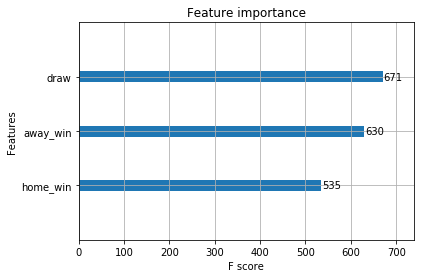

In [16]:
model.fit(X, y)

plot_importance(model)
plt.show()

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

model = xgb.XGBClassifier()
subsample = [0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 1]
param_grid = dict(subsample=subsample)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.854685 using {'subsample': 1}
-0.867247 (0.041107) with: {'subsample': 0.2}
-0.861300 (0.043872) with: {'subsample': 0.3}
-0.865193 (0.046833) with: {'subsample': 0.4}
-0.860940 (0.046470) with: {'subsample': 0.5}
-0.856765 (0.042065) with: {'subsample': 0.6}
-0.861376 (0.045176) with: {'subsample': 0.7}
-0.858051 (0.044914) with: {'subsample': 0.8}
-0.858243 (0.044478) with: {'subsample': 0.9}
-0.854685 (0.044335) with: {'subsample': 1}


In [38]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target])
        print(xgtrain.feature_names)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

target = 'result'
train = data[['home_win', 'draw', 'away_win', 'result']]

predictors = [x for x in train.columns if x not in [target]]
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 num_class=3,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, train, predictors)

['f0', 'f1', 'f2']


XGBoostError: b'[14:05:45] src/metric/rank_metric.cc:88: Check failed: preds.size() == info.labels_.size() (4296 vs. 1432) label size predict size not match\n\nStack trace returned 2 entries:\n[bt] (0) 0   libxgboost.dylib                    0x000000010efef683 dmlc::StackTrace[abi:cxx11]() + 67\n[bt] (1) 1   libstdc++.6.dylib                   0x000000010f46c0a0 vtable for std::__cxx11::basic_stringbuf<char, std::char_traits<char>, std::allocator<char> > + 16\n\n'